,prop,other_resp,other_prop,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
0,50,50,50,43000,26,60,31000,20,4.2,3.0,2.8,50
1,50,20,20,12000,7,20,38000,20,1.9,4.4,2.9,50
2,120,50,80,88000,50,20,69000,12,3.3,3.8,3.4,80
3,50,50,50,24000,50,60,26000,14,3.6,3.8,2.6,50
4,100,50,50,137000,24,60,43000,4,3.6,2.5,2.7,100


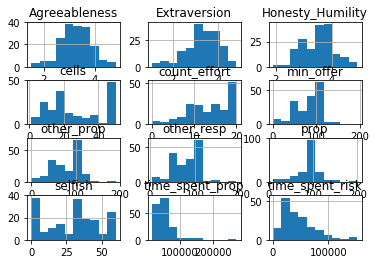

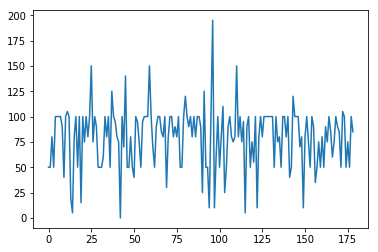

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("./UG_HH_NEW_continuous_no200.xls")
df = df.dropna()

#print(df[50:])

# Show head and histograms
display(df.head())
df.hist()

# Plot sample figure for min_offers
plt.figure()

x = range(0, len(df['prop']))
x1 = df['min_offer']

plt.plot(x, x1)

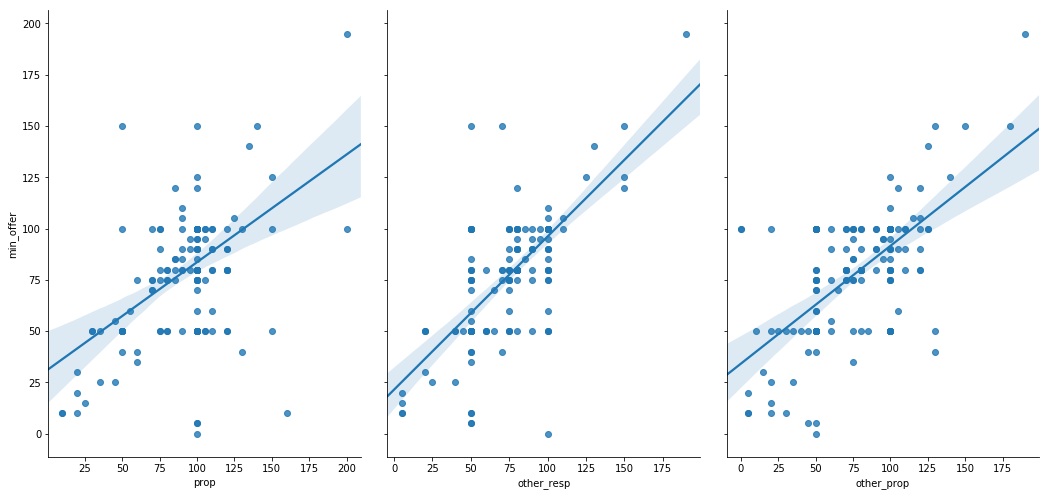

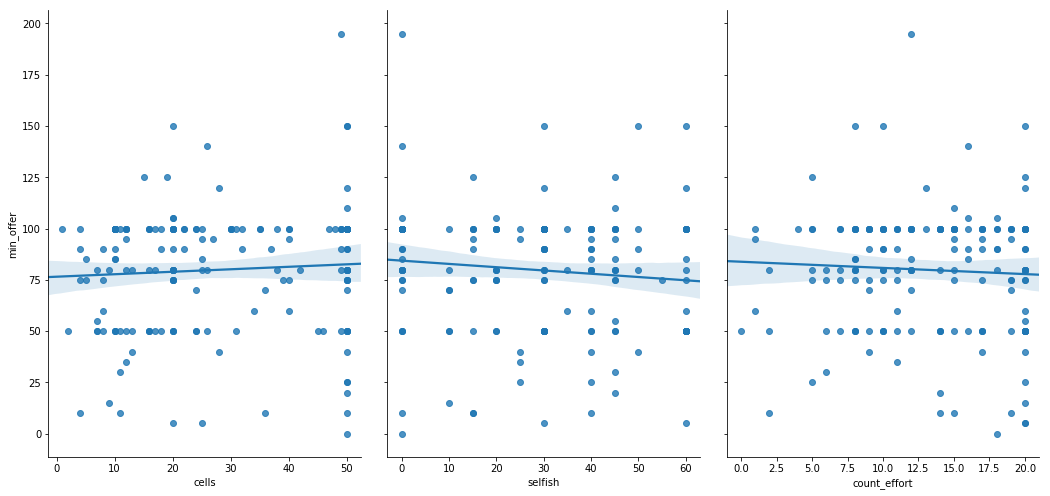

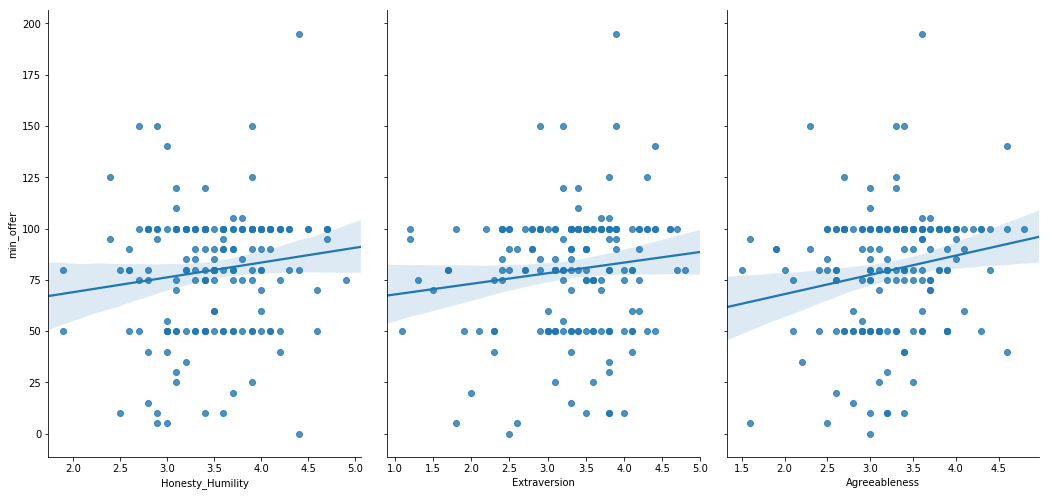

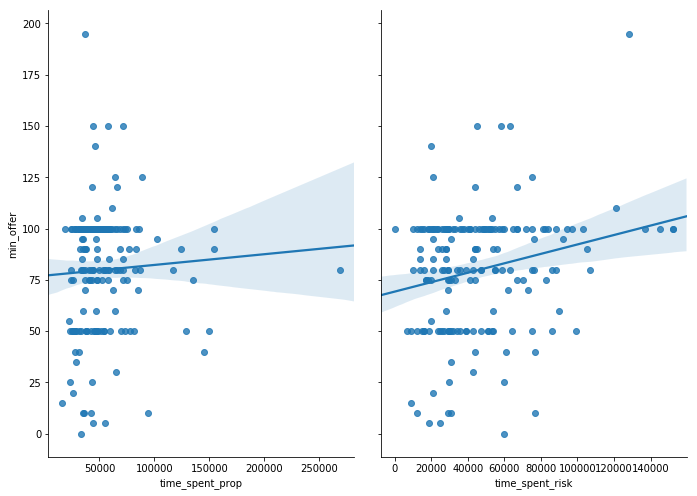

In [2]:
sb.pairplot(df, x_vars=('prop','other_resp','other_prop'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('cells', 'selfish','count_effort'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('Honesty_Humility', 'Extraversion','Agreeableness'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')
sb.pairplot(df, x_vars=('time_spent_prop', 'time_spent_risk'), y_vars='min_offer', height=7, aspect=0.7, kind='reg')

In [3]:
#manual ablation
#df = df.drop(columns=['cells','selfish','count_effort','Honesty_Humility','Extraversion','Agreeableness','time_spent_risk','time_spent_prop'])

In [4]:
from sklearn.linear_model import LinearRegression
# Split into inputs and oututs
x = df.iloc[:, :-1].values

y = df.iloc[:, -1:].values
NB_FEATURES = x.shape[1]
#print(x)
#print(y)

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)
#print(xTrain)
#print(yTrain)

# regressor = LinearRegression(copy_X=True).fit(xTrain, yTrain)

# print("Intercept:", regressor.intercept_)
# print("Coef:", regressor.coef_)

# yPredict = regressor.predict(xTest)
# print("R2:", r2_score(yTest, yPredict))

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPredict)})
# #print(out_data)

# out_data.plot(figsize=(30,10))

In [5]:
@np.vectorize
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

@np.vectorize
def sigmoid1024(x):
    return (1024**x/(1024**x + 1))

@np.vectorize
def sigmoid128(x):
    return (128**x/(128**x + 1))

# @np.vectorize
# def loss(x):
#     x = (x+10) / 40
#     return (1 - (sigmoid1024(x) * np.cos(x/np.pi))) / 2
    
# @np.vectorize
# def gain(x):
#     return 2 - loss(x)

# @np.vectorize
def gain(x):
    x = (x - 16) / 40
    return (sigmoid1024(x) *  np.cos(x/np.pi))

@np.vectorize
def loss(x):
    x_ = (x) / 40
    x = (x + 32) / 40
    return (1 - sigmoid1024(x) *  np.cos(x_/np.pi))

In [18]:
x = np.linspace(-300, 300, 1000)
y = gain(x)

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

TypeError: gain() missing 1 required positional argument: 'predicted'

In [ ]:
y = loss(x)
print("Min value: ", x[y.argmin()])

df = pd.DataFrame({'x':x, 'y':y})
df.plot.line(x='x', y='y')

In [87]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES):
        self.size = size
        self.nb_features = nb_features
    
    def fit_predict(self, xTrain, yTrain, size=None):
        size = size or self.size or len(xTrain) * 4
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        xRes = []
        yRes = []
        for _ in range(size):
            target = np.random.choice(targets)
            target_mask = yTrain.ravel()==target
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = int(np.random.randint(self.nb_features))
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        return np.array(xRes), np.array(yRes)
        
        

array([3.00792268e+01, 2.76780174e+01, 3.33741456e+01, 2.85864737e+04,
       1.64649948e+01, 1.92670088e+01, 2.62934144e+04, 5.32999045e+00,
       5.68555719e-01, 7.27117451e-01, 6.02465012e-01])

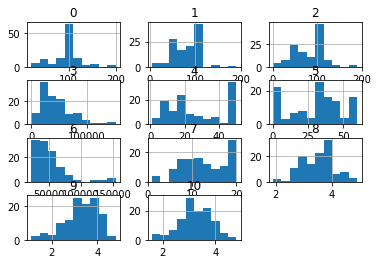

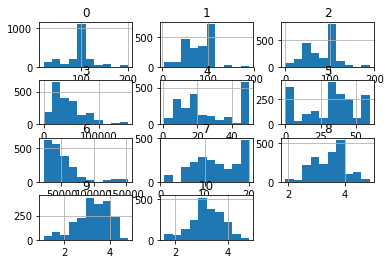

In [121]:
da = DACombine()
aX, aY = da.fit_predict(xTrain, yTrain, size=2048)
pd.DataFrame(data=xTrain).hist()
pd.DataFrame(data=aX).hist()
# items = np.arange(11)
# items[:4]
# items[items[:4]]
aX.std(axis=0)

In [108]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    denum = tf.constant(40.0)
    x = tf.math.subtract(y_true, y_pred) - tf.constant(16.0)
    x = tf.math.truediv(x, denum)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)

def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(40.0)
    x0 = tf.math.subtract(y_true, y_pred) + tf.constant(16.0)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return K.mean(0.5 * (tf.math.subtract(one, tf.math.multiply(left_mul, right_mul)))**2)

def loss2_tf(y_true, y_pred):
    l = loss_tf(y_true, y_pred)
    return 100*l

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: mse)
    """
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mae"]
    model = Sequential()
    model.add(Dense(16, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

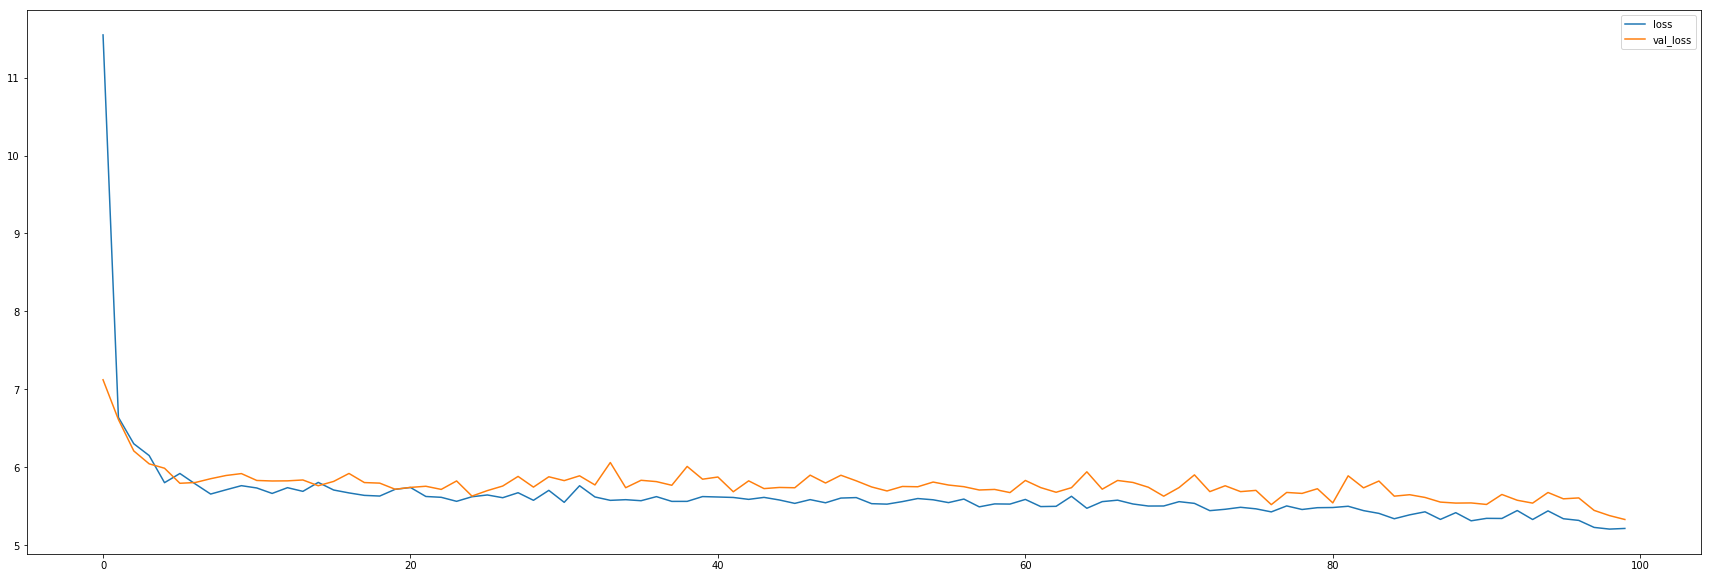

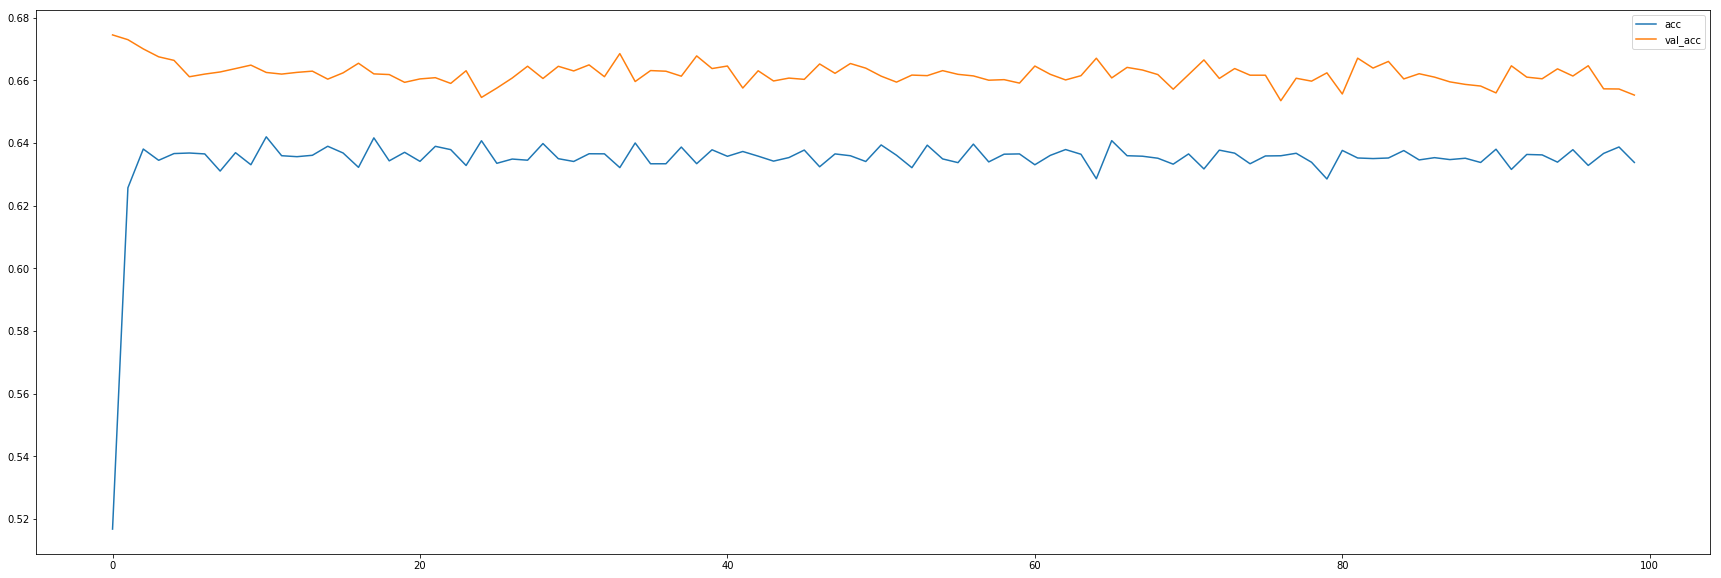

In [113]:
#sci-kit like training
sm = keras_model(loss=loss2_tf, metrics=[gain_tf])
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024)
history = sm.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_split=1/4, epochs=100, batch_size=30, verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(figsize=(30,10))

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(figsize=(30, 10))

smPredict = sm.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
stl = sm.score(xTest, yTest, verbose=0)
#print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
##out_data.plot(figsize=(30,10))

In [114]:
xx = sm.predict(xTrain)
xx

array([15.971181 , 20.384272 , 16.72928  , 21.525629 , 32.446507 ,
       18.533747 , 22.95782  , 15.54036  , 24.28555  , 31.660048 ,
       27.475658 , 54.029457 , 11.227554 , 37.02261  , 19.248386 ,
       21.547834 , 24.826471 , 24.098743 , 15.032712 , 19.77458  ,
       23.560015 , 18.984777 , 30.884377 , 21.763735 , 17.288372 ,
       22.31087  , 12.3854475, 40.821613 , 17.392202 , 26.589787 ,
       13.488069 , 19.59737  , 19.781607 , 25.531994 ,  8.079759 ,
       19.005562 , 16.676222 , 30.962008 , 28.642231 , 22.71896  ,
       20.050892 , 29.919962 , 28.919325 , 24.707298 , 14.207163 ,
       27.924461 , 18.21082  , 51.89425  , 20.889584 , 22.244404 ,
       25.352678 , 26.833548 , 27.377548 , 26.552471 , 20.62033  ,
       13.445794 , 17.201    , 25.033749 , 23.367546 , 14.452516 ,
       28.725931 , 24.209095 , 36.635498 , 20.789623 , 27.515001 ,
       13.430456 , 16.62445  , 28.562838 ,  7.517704 , 13.18613  ,
       30.041945 , 22.284054 , 24.375414 , 16.895939 , 26.3156

In [94]:
loss_baseline = "mse"
MAX_GAIN = 200.0

def gain(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def gain_mean(min_offer, predicted):
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res.mean()

In [39]:
history.history

{'gain_tf': [0.658888066752573,
  0.6480121083473891,
  0.6293232970023424,
  0.6467032271824525,
  0.6417600211132778,
  0.6485115885734558,
  0.6376089105445347,
  0.6462434952178698,
  0.6366923250509112,
  0.6305303024442008,
  0.64319503106428,
  0.6424478627322765,
  0.6541234094105409,
  0.6373766399501415,
  0.6311964339084839,
  0.6491837039422453,
  0.6347471174229397,
  0.6449344821190566,
  0.636289802829871,
  0.6344103330976507,
  0.6339218074016357,
  0.6314332692810659,
  0.6426473996612463,
  0.6243814283542419,
  0.6446679140744584,
  0.6427923240018695,
  0.6317006081677554,
  0.6455625597010838,
  0.6384460122397776,
  0.6407467716195611,
  0.6334004844172617,
  0.6324964641185289,
  0.6390770271922765,
  0.6422352455974965,
  0.629198718606756,
  0.6292815871453017,
  0.6355462603354722,
  0.6366823737540942,
  0.637933423010151,
  0.642429744259695,
  0.6381065905763862,
  0.635229888257016,
  0.632240482930387,
  0.6329758649461725,
  0.6433589291036799,
  0.6290